In [1]:
"""Showcase a PMF-based Brownian coagulation example.

Builds a lognormal PMF aerosol, configures Brownian coagulation with
``distribution_type="discrete"``, runs a short guarded step, and plots PMF
concentration before/after execution to visualize redistribution. Designed
for quick execution with a small grid and modest sub-steps.

Example:
    Run the script to generate before/after concentration curves for a
    discrete PMF aerosol using the public ``par.dynamics`` API.
"""

'Showcase a PMF-based Brownian coagulation example.\n\nBuilds a lognormal PMF aerosol, configures Brownian coagulation with\n``distribution_type="discrete"``, runs a short guarded step, and plots PMF\nconcentration before/after execution to visualize redistribution. Designed\nfor quick execution with a small grid and modest sub-steps.\n\nExample:\n    Run the script to generate before/after concentration curves for a\n    discrete PMF aerosol using the public ``par.dynamics`` API.\n'

# Coagulation Pattern 1: PMF

Brownian coagulation using the public `par.dynamics` API with a
discrete/PMF representation:

1. Build a Brownian coagulation strategy with
   `distribution_type="discrete"`.
2. Wrap it in `par.dynamics.Coagulation`.
3. Run a short, fast step on a PMF aerosol and visualize the change.

In [2]:
# In Colab uncomment the following command to install particula:
#!pip install particula[extra] --quiet
import matplotlib.pyplot as plt
import numpy as np
import particula as par

## Build a PMF aerosol

We create a modest lognormal PMF and attach it to an ambient atmosphere.

In [3]:
# Radius bins (log-spaced, extended to 10 microns for visibility)
radius_bins = np.logspace(-8, -5, 150)  # m (10 nm to 10 um)

# Lognormal PMF (concentration per bin) - higher concentration for visible change
concentration_pmf = par.particles.get_lognormal_pmf_distribution(
    x_values=radius_bins,
    mode=np.array([80e-9]),
    geometric_standard_deviation=np.array([1.5]),
    number_of_particles=np.array(
        [1e10]
    ),  # m^-3 total (increased for visibility)
)

# Atmosphere (ambient, non-condensing)
atmosphere = (
    par.gas.AtmosphereBuilder()
    .set_temperature(25, "degC")
    .set_pressure(1, "atm")
    .build()
)

# PMF particle representation
particles_pmf = (
    par.particles.PresetParticleRadiusBuilder()
    .set_distribution_type("pmf")
    .set_radius_bins(radius_bins, radius_bins_units="m")
    .set_concentration(concentration_pmf, concentration_units="m^-3")
    .set_density(np.array([1_000.0]), density_units="kg/m^3")
    .set_charge(np.zeros_like(radius_bins))
    .build()
)

# Aerosol object
pmf_aerosol = par.Aerosol(atmosphere=atmosphere, particles=particles_pmf)

## Configure coagulation (discrete)

Use the Brownian builder with `distribution_type="discrete"`, then wrap in
the public `Coagulation` runnable.

In [4]:
coagulation_strategy = (
    par.dynamics.BrownianCoagulationBuilder()
    .set_distribution_type("discrete")
    .build()
)
coagulation_process = par.dynamics.Coagulation(
    coagulation_strategy=coagulation_strategy
)

print(coagulation_process)

## Execute a short coagulation step

Keep the time step and sub-steps small for quick execution. The runnable
updates the aerosol in-place and returns it.

In [5]:
# Set up time and sub-steps for the coagulation process
# Longer time span for visible coagulation effect
time_step = 3600  # 1 hour per step
sub_steps = 100

radii = pmf_aerosol.particles.get_radius()
pmf_before = np.copy(pmf_aerosol.particles.concentration)

# Perform coagulation process for step 1
pmf_aerosol = coagulation_process.execute(
    pmf_aerosol, time_step=time_step, sub_steps=sub_steps
)
radii_after_step_1 = pmf_aerosol.particles.get_radius()
pmf_after_step_1 = np.copy(pmf_aerosol.particles.concentration)

# Perform coagulation process for step 2
pmf_aerosol = coagulation_process.execute(
    pmf_aerosol, time_step=time_step, sub_steps=sub_steps
)
radii_after_step_2 = pmf_aerosol.particles.get_radius()
pmf_after_step_2 = np.copy(pmf_aerosol.particles.concentration)

## Plot: concentration before/after

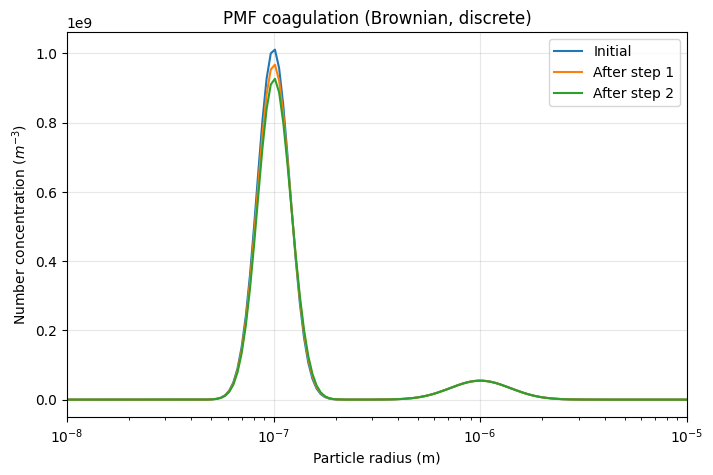

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(radii, pmf_before, label="Initial", color="tab:blue")
ax.plot(
    radii_after_step_1,
    pmf_after_step_1,
    label="After step 1",
    color="tab:orange",
)
ax.plot(
    radii_after_step_2,
    pmf_after_step_2,
    label="After step 2",
    color="tab:green",
)
ax.set_xscale("log")
ax.set_xlim(1e-8, 1e-5)  # 10 nm to 10 um
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel(r"Number concentration ($m^{-3}$)")
ax.set_title("PMF coagulation (Brownian, discrete)")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

## Summary

- Strategy: `BrownianCoagulationBuilder().set_distribution_type("discrete")`
- Runnable: `par.dynamics.Coagulation`
- Representation: PMF (bin-based number concentration)
- Runtime guardrails: small grid, short horizon for fast execution